# FrequencyStorm - Variable Duration Storms

This notebook demonstrates how to generate HEC-HMS "Frequency Storm" hyetographs
for different storm durations (6-hour, 12-hour, 24-hour, 48-hour, etc.).

## Key Concepts

The FrequencyStorm module uses the HMS "User Specified Pattern" algorithm:

1. **Cumulative Pattern Scaling**: 
   - Same algorithm as HMS "Hypothetical Storm -> User Specified Pattern"
   - Supports variable durations via `total_duration_min` parameter
   - Validated against HCFCD M3 ground truth for 24-hour storms

2. **DDF Interface** (`generate_from_ddf`):
   - Takes standard TP-40 depth-duration-frequency data
   - Uses the last duration as the storm duration

## References

- [HMS Frequency Storm Documentation](https://www.hec.usace.army.mil/confluence/hmsdocs/hmstrm/meteorology/precipitation/frequency-storm)
- [HMS Hypothetical Storm Documentation](https://www.hec.usace.army.mil/confluence/hmsdocs/hmstrm/meteorology/precipitation/hypothetical-storm)

In [1]:
# pip install hms-commander

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hms_commander import FrequencyStorm

print(f"FrequencyStorm module loaded")
print(f"Available methods: generate_hyetograph, generate_from_ddf, get_pattern_info")

FrequencyStorm module loaded
Available methods: generate_hyetograph, generate_from_ddf, get_pattern_info


## Example DDF Data (TP-40 Houston Area)

For Frequency Storms, you need cumulative precipitation depths at various durations.
The storm duration equals the **longest duration** in your table.

| Duration | Depth (1% AEP) |
|----------|----------------|
| 5 min    | 1.20"          |
| 15 min   | 2.10"          |
| 30 min   | 3.18"          |
| 60 min   | 4.30"          |
| 2 hr     | 5.70"          |
| 3 hr     | 6.80"          |
| 6 hr     | 9.10"          |
| 12 hr    | 11.10"         |
| 24 hr    | 13.20"         |
| 48 hr    | 16.20"         |

In [3]:
# Complete DDF data (1% AEP, Houston area example)
# To create a storm of a specific duration, use total_depth for that duration

FULL_DEPTHS = [1.20, 2.10, 3.18, 4.30, 5.70, 6.80, 9.10, 11.10, 13.20, 16.20]
FULL_DURATIONS = [5, 15, 30, 60, 120, 180, 360, 720, 1440, 2880]  # minutes

# Duration names for reference
DURATION_NAMES = ['5min', '15min', '30min', '1hr', '2hr', '3hr', '6hr', '12hr', '24hr', '48hr']

# Create a lookup dictionary
depth_for_duration = dict(zip(FULL_DURATIONS, FULL_DEPTHS))
print("Available storm depths:")
for dur, depth, name in zip(FULL_DURATIONS, FULL_DEPTHS, DURATION_NAMES):
    print(f"  {name:>6}: {depth:.2f} inches ({dur} min)")

Available storm depths:
    5min: 1.20 inches (5 min)
   15min: 2.10 inches (15 min)
   30min: 3.18 inches (30 min)
     1hr: 4.30 inches (60 min)
     2hr: 5.70 inches (120 min)
     3hr: 6.80 inches (180 min)
     6hr: 9.10 inches (360 min)
    12hr: 11.10 inches (720 min)
    24hr: 13.20 inches (1440 min)
    48hr: 16.20 inches (2880 min)


## 6-Hour Storm

Generate a 6-hour storm using `generate_hyetograph` with `total_duration_min=360`.

In [4]:
# 6-hour storm (360 minutes)
hyeto_6hr = FrequencyStorm.generate_hyetograph(
    total_depth_inches=9.10,  # 6-hour depth from DDF table
    total_duration_min=360,   # 6 hours in minutes
    time_interval_min=5, 
    peak_position_pct=67
)

print(f"6-hour storm:")
print(f"  Intervals: {len(hyeto_6hr)} (6hr / 5min = {360//5})")
print(f"  Total: {hyeto_6hr['cumulative_depth'].iloc[-1]:.2f} inches")
print(f"  Peak: {hyeto_6hr['incremental_depth'].max():.3f} inches")
peak_idx = hyeto_6hr['incremental_depth'].idxmax()
print(f"  Peak at: {hyeto_6hr.loc[peak_idx, 'hour']:.1f} hours (67% of 6hr = 4.0hr)")

6-hour storm:
  Intervals: 73 (6hr / 5min = 72)
  Total: 9.10 inches
  Peak: 1.479 inches
  Peak at: 4.2 hours (67% of 6hr = 4.0hr)


## 12-Hour Storm

In [5]:
# 12-hour storm (720 minutes)
hyeto_12hr = FrequencyStorm.generate_hyetograph(
    total_depth_inches=11.10,  # 12-hour depth from DDF table
    total_duration_min=720,    # 12 hours in minutes
    time_interval_min=5,
    peak_position_pct=67
)

print(f"12-hour storm:")
print(f"  Intervals: {len(hyeto_12hr)} (12hr / 5min = {720//5})")
print(f"  Total: {hyeto_12hr['cumulative_depth'].iloc[-1]:.2f} inches")
peak_idx = hyeto_12hr['incremental_depth'].idxmax()
print(f"  Peak at: {hyeto_12hr.loc[peak_idx, 'hour']:.1f} hours (67% of 12hr = 8.0hr)")

12-hour storm:
  Intervals: 145 (12hr / 5min = 144)
  Total: 11.10 inches
  Peak at: 8.2 hours (67% of 12hr = 8.0hr)


## 24-Hour Storm (HCFCD M3 Compatible)

The 24-hour storm is validated against HCFCD M3 ground truth to 10^-6 precision.

In [6]:
# 24-hour storm (1440 minutes) - default duration
hyeto_24hr = FrequencyStorm.generate_hyetograph(
    total_depth_inches=13.20,  # 24-hour depth from DDF table
    total_duration_min=1440,   # 24 hours in minutes (default)
    time_interval_min=5,       # 5-minute intervals (default)
    peak_position_pct=67       # 67% peak position (default)
)

print(f"24-hour storm (HCFCD M3 compatible):")
print(f"  Intervals: {len(hyeto_24hr)} (24hr / 5min = {1440//5})")
print(f"  Total: {hyeto_24hr['cumulative_depth'].iloc[-1]:.2f} inches")
print(f"  Peak: {hyeto_24hr['incremental_depth'].max():.3f} inches")
peak_idx = hyeto_24hr['incremental_depth'].idxmax()
print(f"  Peak at: {hyeto_24hr.loc[peak_idx, 'hour']:.1f} hours (67% of 24hr = 16.1hr)")

24-hour storm (HCFCD M3 compatible):
  Intervals: 289 (24hr / 5min = 288)
  Total: 13.20 inches
  Peak: 1.200 inches
  Peak at: 16.2 hours (67% of 24hr = 16.1hr)


## 48-Hour Storm

In [7]:
# 48-hour storm (2880 minutes)
hyeto_48hr = FrequencyStorm.generate_hyetograph(
    total_depth_inches=16.20,  # 48-hour depth from DDF table
    total_duration_min=2880,   # 48 hours in minutes
    time_interval_min=5,
    peak_position_pct=67
)

print(f"48-hour storm:")
print(f"  Intervals: {len(hyeto_48hr)} (48hr / 5min = {2880//5})")
print(f"  Total: {hyeto_48hr['cumulative_depth'].iloc[-1]:.2f} inches")
peak_idx = hyeto_48hr['incremental_depth'].idxmax()
print(f"  Peak at: {hyeto_48hr.loc[peak_idx, 'hour']:.1f} hours (67% of 48hr = 32.2hr)")

48-hour storm:
  Intervals: 577 (48hr / 5min = 576)
  Total: 16.20 inches
  Peak at: 32.2 hours (67% of 48hr = 32.2hr)


## Visual Comparison of Storm Durations

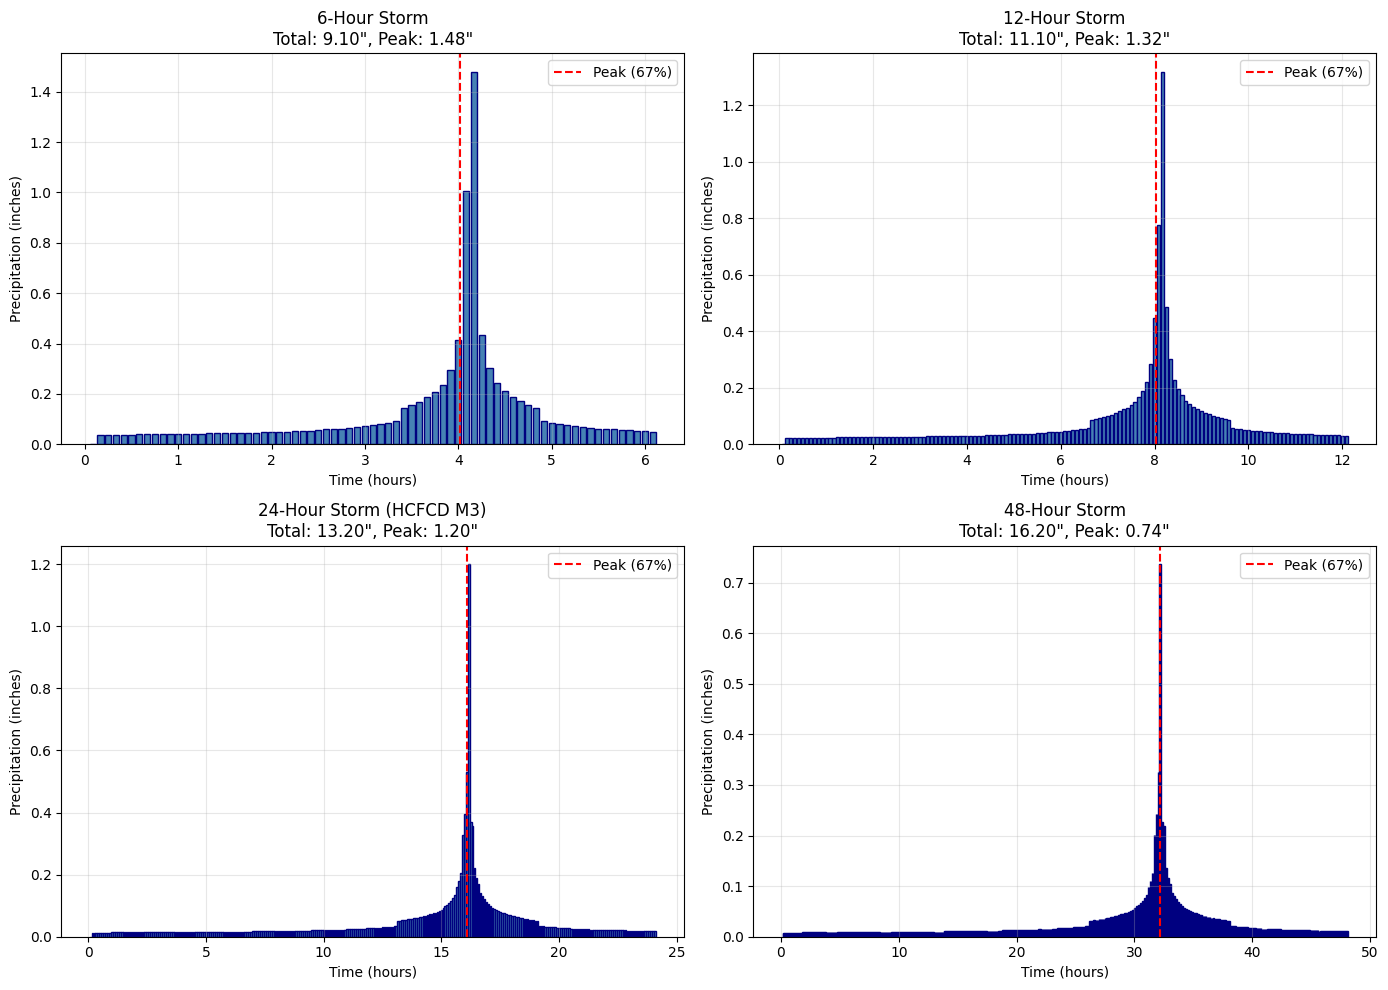

Storm comparison complete.


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 6-hour
ax = axes[0, 0]
ax.bar(hyeto_6hr['hour'], hyeto_6hr['incremental_depth'], width=5/60*0.8, color='steelblue', edgecolor='navy')
ax.axvline(x=6*0.67, color='red', linestyle='--', label='Peak (67%)')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Precipitation (inches)')
total_6hr = hyeto_6hr['cumulative_depth'].iloc[-1]
peak_6hr = hyeto_6hr['incremental_depth'].max()
ax.set_title(f'6-Hour Storm\nTotal: {total_6hr:.2f}", Peak: {peak_6hr:.2f}"')
ax.legend()
ax.grid(True, alpha=0.3)

# 12-hour
ax = axes[0, 1]
ax.bar(hyeto_12hr['hour'], hyeto_12hr['incremental_depth'], width=5/60*0.8, color='steelblue', edgecolor='navy')
ax.axvline(x=12*0.67, color='red', linestyle='--', label='Peak (67%)')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Precipitation (inches)')
total_12hr = hyeto_12hr['cumulative_depth'].iloc[-1]
peak_12hr = hyeto_12hr['incremental_depth'].max()
ax.set_title(f'12-Hour Storm\nTotal: {total_12hr:.2f}", Peak: {peak_12hr:.2f}"')
ax.legend()
ax.grid(True, alpha=0.3)

# 24-hour
ax = axes[1, 0]
ax.bar(hyeto_24hr['hour'], hyeto_24hr['incremental_depth'], width=5/60*0.8, color='steelblue', edgecolor='navy')
ax.axvline(x=24*0.67, color='red', linestyle='--', label='Peak (67%)')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Precipitation (inches)')
total_24hr = hyeto_24hr['cumulative_depth'].iloc[-1]
peak_24hr = hyeto_24hr['incremental_depth'].max()
ax.set_title(f'24-Hour Storm (HCFCD M3)\nTotal: {total_24hr:.2f}", Peak: {peak_24hr:.2f}"')
ax.legend()
ax.grid(True, alpha=0.3)

# 48-hour
ax = axes[1, 1]
ax.bar(hyeto_48hr['hour'], hyeto_48hr['incremental_depth'], width=5/60*0.8, color='steelblue', edgecolor='navy')
ax.axvline(x=48*0.67, color='red', linestyle='--', label='Peak (67%)')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Precipitation (inches)')
total_48hr = hyeto_48hr['cumulative_depth'].iloc[-1]
peak_48hr = hyeto_48hr['incremental_depth'].max()
ax.set_title(f'48-Hour Storm\nTotal: {total_48hr:.2f}", Peak: {peak_48hr:.2f}"')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Storm comparison complete.")

## Peak Position Options

HMS supports 5 standard peak positions: 25%, 33%, 50%, 67%, and 75%.

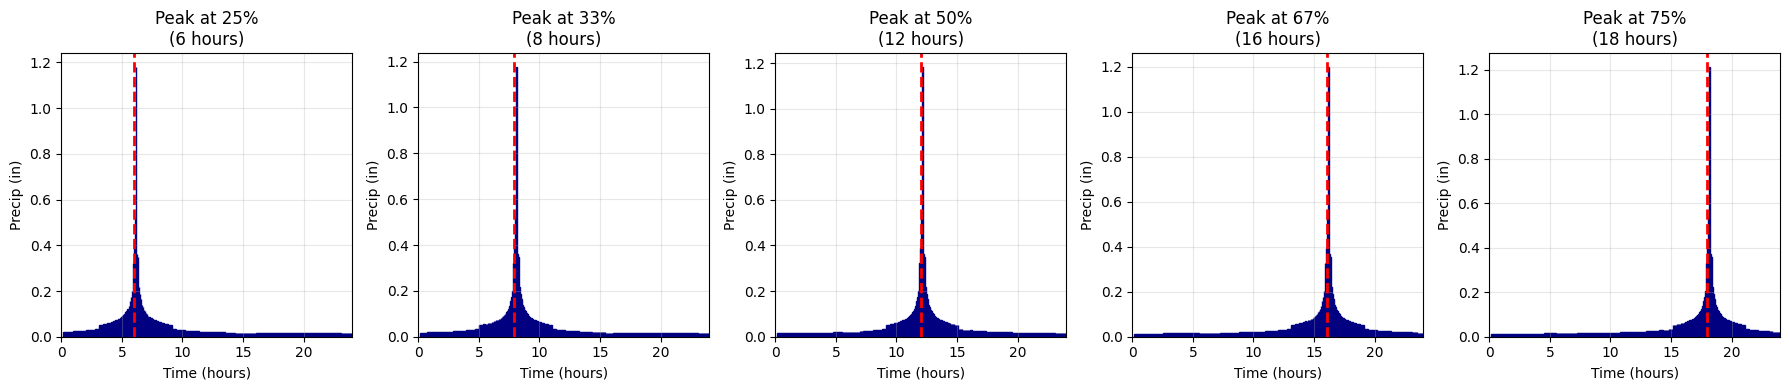

Peak position comparison complete.


In [9]:
fig, axes = plt.subplots(1, 5, figsize=(18, 4))

peak_positions = [25, 33, 50, 67, 75]

for ax, pct in zip(axes, peak_positions):
    hyeto = FrequencyStorm.generate_hyetograph(
        total_depth_inches=13.20,
        total_duration_min=1440,
        time_interval_min=5,
        peak_position_pct=pct
    )
    
    ax.bar(hyeto['hour'], hyeto['incremental_depth'], width=5/60*0.8, color='steelblue', edgecolor='navy')
    ax.axvline(x=24*pct/100, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Precip (in)')
    ax.set_title(f'Peak at {pct}%\n({24*pct/100:.0f} hours)')
    ax.set_xlim(0, 24)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Peak position comparison complete.")

## Using generate_from_ddf() Convenience Method

The `generate_from_ddf()` method takes DDF data and uses the last duration as the storm duration.

In [10]:
# Using generate_from_ddf for 24-hour storm
# Uses depths[0:9] corresponding to durations up to 1440 min (24 hr)
depths_24hr = FULL_DEPTHS[:9]  # Up to 24-hour
durations_24hr = FULL_DURATIONS[:9]

hyeto_ddf = FrequencyStorm.generate_from_ddf(
    depths_24hr, 
    durations_24hr,
    peak_position_pct=67,
    time_interval_min=5
)

print(f"24-hr via generate_from_ddf:")
print(f"  Total: {hyeto_ddf['cumulative_depth'].iloc[-1]:.2f} inches")
print(f"  Intervals: {len(hyeto_ddf)}")
print(f"  Peak: {hyeto_ddf['incremental_depth'].max():.3f} inches")

# Verify it matches direct generate_hyetograph
diff = (hyeto_ddf['incremental_depth'] - hyeto_24hr['incremental_depth']).abs().max()
print(f"\nMatch with generate_hyetograph: {diff < 1e-10}")

24-hr via generate_from_ddf:
  Total: 13.20 inches
  Intervals: 289
  Peak: 1.200 inches

Match with generate_hyetograph: True


## Pattern Information

View details about the bundled temporal pattern.

In [11]:
info = FrequencyStorm.get_pattern_info()

print("Bundled Pattern Information:")
print(f"  Intervals: {info['num_intervals']}")
print(f"  Time interval: {info['time_interval_min']} minutes")
print(f"  Duration: {info['total_duration_min']} minutes ({info['total_duration_min']/60:.0f} hours)")
print(f"  Peak position: {info['peak_position']*100:.0f}%")
print(f"  Peak fraction: {info['peak_fraction']:.4f}")
print(f"  Source: {info['source']}")

Bundled Pattern Information:
  Intervals: 288
  Time interval: 5 minutes
  Duration: 1440 minutes (24 hours)
  Peak position: 67%
  Peak fraction: 0.0909
  Source: HCFCD Model D (Brays Bayou) - 1% AEP ground truth


## Summary

| Duration | total_duration_min | Intervals (5-min) | Example Total Depth |
|----------|-------------------|-------------------|--------------------|
| 6-hour   | 360               | 72                | 9.10"              |
| 12-hour  | 720               | 144               | 11.10"             |
| 24-hour  | 1440 (default)    | 288               | 13.20"             |
| 48-hour  | 2880              | 576               | 16.20"             |

**Key Points:**
- Use `generate_hyetograph(total_depth_inches, total_duration_min=...)` for any duration
- Use `generate_from_ddf(depths, durations)` when you have TP-40 data
- 24-hour storms validated against HCFCD M3 Model D to 10^-6 precision
- Peak positions: 25%, 33%, 50%, 67% (default), 75%
- Algorithm matches HMS "Hypothetical Storm -> User Specified Pattern"
- Returns DataFrame with columns: `hour`, `incremental_depth`, `cumulative_depth`